## Invoice OCR Parser:

## Quick Intro
The purpose of this notebook is to quickly get an idea of how Microsoft Azure Computer Vision API works and examine approaches to extract text data from invoice images/pdfs

In [1]:
import time 
import requests
import cv2
import operator
import numpy as np

# Import library to display results
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
%matplotlib inline 
# Display images within Jupyter

In order to run this notebook you need to create a json file in the following format and set the path to it in `credentials_path`:
```
{
    "endpoint":"<your-computer-vision-endpoint-url-here>",
    "api_key":"<your-api-key-here>"
}
```
This hides your keys and avoids the possibility of a user accidentely pushing their keys publicly to a Github (or similar) repository.

## Setting Variables:


In [2]:
credentials_path = '../credentials.json'

In [3]:
import json
import os


# Azure Computer Vision API variables
with open(credentials_path) as f:
    data = json.load(f)
    endpoint = data['endpoint'] # full endpoint from the Azure portal
    subscription_key = data['api_key'] #  api-key
    
_maxNumRetries = 10
images_folder = '../dataset'
# Get image path
read_image_path = os.path.join (images_folder, "6.png") # For simplicity, we will be focusing on a single image example in this notebook.

## Reading Image and getting OCR results:
2 API calls are needed: one to send the image and one to retrieve the results

In [4]:
''' Using parts of the quickstart script found here: 
https://github.com/Azure-Samples/cognitive-services-quickstart-code/blob/master/python/ComputerVision/ComputerVisionQuickstart.py
'''
from azure.cognitiveservices.vision.computervision import ComputerVisionClient
from azure.cognitiveservices.vision.computervision.models import OperationStatusCodes
from azure.cognitiveservices.vision.computervision.models import VisualFeatureTypes
from msrest.authentication import CognitiveServicesCredentials

from array import array
import os
from PIL import Image
import sys
import time

'''
Authenticate your credentials and creates a client.
'''
computervision_client = ComputerVisionClient(endpoint, CognitiveServicesCredentials(subscription_key))

# Read image (local)
read_image = open(read_image_path, "rb")

# Call API with image and raw response (allows you to get the operation location)
read_response = computervision_client.read_in_stream(read_image, raw=True)
# Get the operation location (URL with ID as last appendage)
read_operation_location = read_response.headers["Operation-Location"]
# Take the ID off and use to get results
operation_id = read_operation_location.split("/")[-1]

# Call the "GET" API and wait for the retrieval of the results
print('==== Retrieving Text from Image - Start ===')
while True:
    read_result = computervision_client.get_read_result(operation_id)
    if read_result.status.lower () not in ['notstarted', 'running']:
        break
    print ('Waiting for result...')
    time.sleep(10)

# Print results, line by line
if read_result.status == OperationStatusCodes.succeeded:
    for text_result in read_result.analyze_result.read_results:
        for line in text_result.lines:
            print(line.text)
print('==== Retrieving Text from Image - End ===')

==== Retrieving Text from Image - Start ===
Waiting for result...
< BankID .Il
09:03
92 %
Kontofaktura
Kontofaktura
Sida 1/2
Datum:
2018-05-10
Fakturanummer:
111122223333444
Stefan Sandpapper
Hej, här kommer kontofakturan för
perioden 10 april - 10 maj
Stanstuvavägen 10
Här samlar vi de köp där du valt att delbetala med Klarna eller
56741 Ankeborg
med faktura med förlängd betaltid samt köp du gjort med
mobiltjänst.
Sverige
Har du nyligen gjort köp som inte är med här? Då kommer de på
nästa kontofaktura. Eftersom betalningen av din förra
kontofaktura inte betalades korrekt eller i tid så har det tillkommit
en förseningsavgift. Svar på de vanligaste frågorna finner du alltid
Översikt
Betalningsinformation
Skuld vid utskick i april:
25 688,92 kr
Att betala denna månad:
4 346 kr
Inbetalningar:
- 1 000,00 kr
Eller betala valfritt belopp *, från
3 659 kr
Nya köp (se baksida):
716,00 kr
Oss tillhanda
2018-05-30
Plusgiro
415 85 02-7
+
Administrativ avgift:
29,00 kr
394,19 kr
OCR-nummer
1111222

### Notes:
The problem with the extracted text is the lack of structure, which will make the parsing of some information very difficult.
Example:
```
Stanstuvavägen 10
Här samlar vi de köp där du valt att delbetala med Klarna eller
56741 Ankeborg
med faktura med förlängd betaltid samt köp du gjort med
mobiltjänst.
Sverige
```
Here we see that the address of the customer which is supposed to be:
```
Stanstuvavägen 10
56741 Ankeborg
Sverige
```
is mixed with some other information. We will try to address this problem later on in the notebook. 
<br></br> **Let's first take a quick look at the OCR results by visualizing them**

## Visualizing OCR results on the image:
The goal of this is to get an idea of the performance of the vision API.

In [5]:
def showResultOnImage(results, img):
    """Display the obtained results onto the input image"""
    img = img[:, :, (2, 1, 0)]
    fig, ax = plt.subplots(figsize=(25, 25))
    ax.imshow(img, aspect='equal')
    
    for text_result in results:
        for line in text_result.lines:
            tl = (line.bounding_box[0], line.bounding_box[1])
            tr = (line.bounding_box[2], line.bounding_box[3])
            br = (line.bounding_box[4], line.bounding_box[5])
            bl = (line.bounding_box[6], line.bounding_box[7])
            text = line.text
            x = [tl[0], tr[0], tr[0], br[0], br[0], bl[0], bl[0], tl[0]]
            y = [tl[1], tr[1], tr[1], br[1], br[1], bl[1], bl[1], tl[1]]
            line = Line2D(x, y, linewidth=1.5, color='red')
            ax.add_line(line)
            ax.text(tl[0], tl[1] - 2, '{:s}'.format(text),
            bbox=dict(facecolor='blue', alpha=0.4),
            fontsize=11, color='white')

    plt.axis('off')
    plt.tight_layout()
    plt.draw()
    plt.show()  

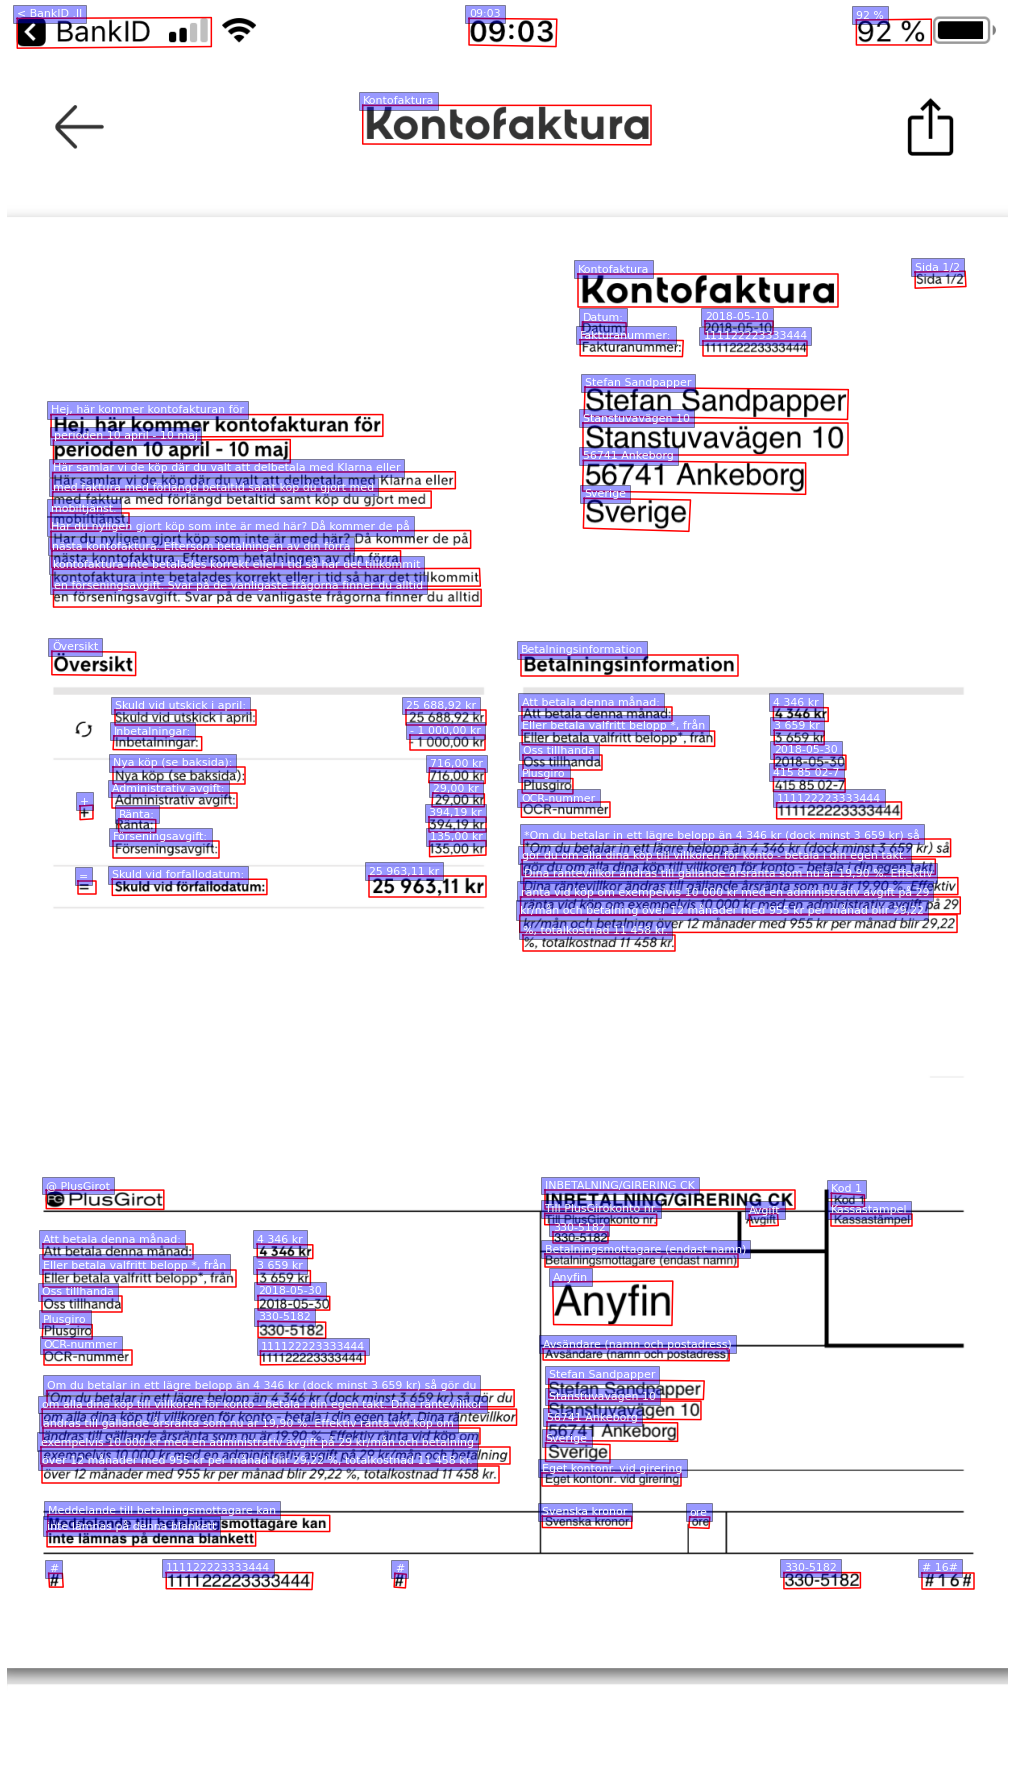

In [6]:
with open(read_image_path, "rb") as f:
    data = f.read()
data8uint = np.frombuffer(data, np.uint8)  # Convert string to an unsigned int array
img = cv2.cvtColor(cv2.imdecode(data8uint, cv2.IMREAD_COLOR), cv2.COLOR_BGR2RGB)
showResultOnImage(read_result.analyze_result.read_results, img)

Impressive results for this image !

## Approaches to solving the text structure problem


### 1 - Cropping the image: (Not recommended)
The idea is to crop the image into multiple images of each 'region' in the invoice. Then get the ocr results for each image.
There are at least a few problems with this approach:
- Multiple additional API calls per image.
- Unreliable (hardcodes the position of the regions, requires the images to always have the exact same resolution, orientation and structure)

In [7]:
from PIL import Image

imageObject = Image.open(read_image_path)

In [8]:
w, h = imageObject.size
print('Image width & height:', w, h)

Image width & height: 1242 2208


In [9]:
overview_region = imageObject.crop((0,750,640,1200))
payment_info_region = imageObject.crop((600,750,1200,1200))
customer_info_region = imageObject.crop((600,300,1200,800))

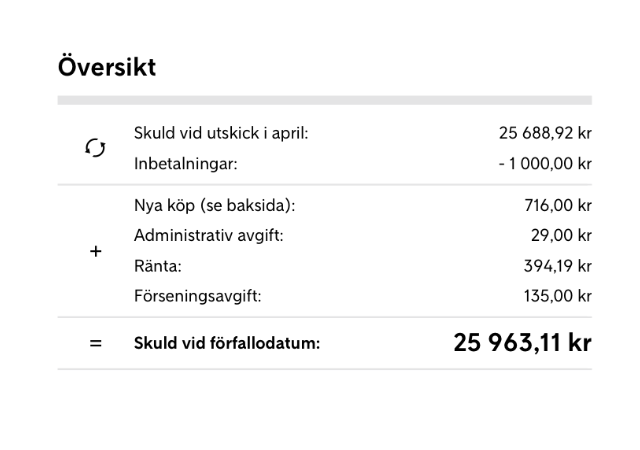

In [10]:
display(overview_region)

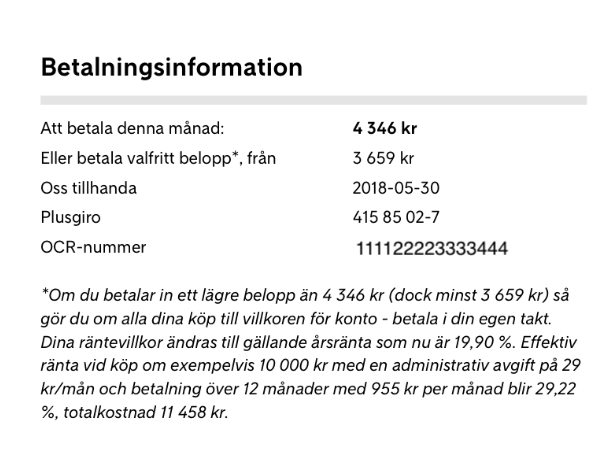

In [11]:
display(payment_info_region)

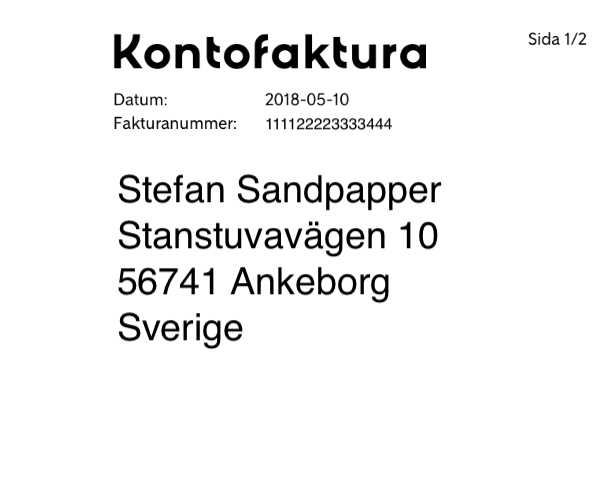

In [12]:
display(customer_info_region)

#### 1.1 Conclusion:
The additional API calls and limitations (related to hardcoding the position of the different regions) of this approach made me decide to abandon this idea.

### 2 - Restructuring the text by using a Clustering algorithm:
The idea is to take advantage of the bounding_box information provided by the api and restructure the text by clustering it into different regions. This example has a single page. In case of an invoice with multiple pages, we can repeat the process for each page and collect the text in the end.

**Advantages**:
 - More flexible (no need to hardcode anything)
**Disadvantages**:
 - May be less accurate than the first approach

In [13]:
# Retrieve the lines and their bounding boxes from the API into a dictionnary
d = {line.text:line.bounding_box for res in read_result.analyze_result.read_results for line in res.lines}

In [14]:
import pandas as pd
df_tmp = pd.DataFrame(d.items(), columns=['Lines', 'Coordinates'])

In [15]:
df_tmp

,Lines,Coordinates
0,< BankID .Il,"[12.0, 14.0, 253.0, 13.0, 253.0, 49.0, 12.0, 5..."
1,09:03,"[573.0, 14.0, 682.0, 15.0, 681.0, 49.0, 573.0,..."
2,92 %,"[1054.0, 16.0, 1147.0, 15.0, 1147.0, 47.0, 105..."
3,Kontofaktura,"[708.0, 331.0, 1031.0, 331.0, 1031.0, 373.0, 7..."
4,Sida 1/2,"[1127.0, 329.0, 1189.0, 328.0, 1190.0, 347.0, ..."
...,...,...
72,Svenska kronor,"[664.0, 1874.0, 775.0, 1874.0, 775.0, 1889.0, ..."
73,ore,"[847.0, 1875.0, 872.0, 1875.0, 871.0, 1889.0, ..."
74,inte lämnas på denna blankett,"[49.0, 1893.0, 308.0, 1893.0, 308.0, 1911.0, 4..."
75,#,"[481.0, 1945.0, 495.0, 1946.0, 494.0, 1963.0, ..."


In [16]:
# Separate the Coordinates column into multiple columns, these will be the features that Kmeans will use to cluster the data
df = pd.DataFrame(df_tmp['Coordinates'].to_list(), 
             columns=['top-left-x','top-left-y', 'top-right-x', 'top-right-y', 'bottom-right-x', 'bottom-right-y',  'bottom-left-x','bottom-left-y'],
             index = df_tmp['Lines'])

In [17]:
from sklearn.cluster import KMeans
# For documents similar to this invoice: n_clusters = 3 seems appropriate, although I didn't spend time tuning this and their may be better values for this parameter.
n_clusters = 2
kmeans = KMeans(n_clusters, random_state=0).fit_predict(df)

In [18]:
df['cluster'] = kmeans

In [19]:
df = df.reset_index()

In [20]:
document = []
for i in range(n_clusters):
    document.append([line for line in df['Lines'][df['cluster']==i]])

In [21]:
import itertools
flat_doc = list(itertools.chain(*document))

In [22]:
flat_doc

['< BankID .Il',
 '09:03',
 '92 %',
 'Kontofaktura',
 'Sida 1/2',
 'Datum:',
 '2018-05-10',
 'Fakturanummer:',
 'Hej, här kommer kontofakturan för',
 'perioden 10 april - 10 maj',
 'Här samlar vi de köp där du valt att delbetala med Klarna eller',
 'med faktura med förlängd betaltid samt köp du gjort med',
 'mobiltjänst.',
 'Har du nyligen gjort köp som inte är med här? Då kommer de på',
 'nästa kontofaktura. Eftersom betalningen av din förra',
 'kontofaktura inte betalades korrekt eller i tid så har det tillkommit',
 'en förseningsavgift. Svar på de vanligaste frågorna finner du alltid',
 'Översikt',
 'Betalningsinformation',
 'Skuld vid utskick i april:',
 '25 688,92 kr',
 'Inbetalningar:',
 '- 1 000,00 kr',
 'Nya köp (se baksida):',
 '716,00 kr',
 '415 85 02-7',
 '+',
 'Administrativ avgift:',
 '29,00 kr',
 '394,19 kr',
 'Ränta:',
 'Förseningsavgift:',
 '135,00 kr',
 '*Om du betalar in ett lägre belopp än 4 346 kr (dock minst 3 659 kr) så',
 'gör du om alla dina köp till villkoren f

In [23]:
structured_text = "\n ".join(sorted(set(flat_doc), key=flat_doc.index)) # Removing duplicate words and structuring the text

In [24]:
structured_text

'< BankID .Il\n 09:03\n 92 %\n Kontofaktura\n Sida 1/2\n Datum:\n 2018-05-10\n Fakturanummer:\n Hej, här kommer kontofakturan för\n perioden 10 april - 10 maj\n Här samlar vi de köp där du valt att delbetala med Klarna eller\n med faktura med förlängd betaltid samt köp du gjort med\n mobiltjänst.\n Har du nyligen gjort köp som inte är med här? Då kommer de på\n nästa kontofaktura. Eftersom betalningen av din förra\n kontofaktura inte betalades korrekt eller i tid så har det tillkommit\n en förseningsavgift. Svar på de vanligaste frågorna finner du alltid\n Översikt\n Betalningsinformation\n Skuld vid utskick i april:\n 25 688,92 kr\n Inbetalningar:\n - 1 000,00 kr\n Nya köp (se baksida):\n 716,00 kr\n 415 85 02-7\n +\n Administrativ avgift:\n 29,00 kr\n 394,19 kr\n Ränta:\n Förseningsavgift:\n 135,00 kr\n *Om du betalar in ett lägre belopp än 4 346 kr (dock minst 3 659 kr) så\n gör du om alla dina köp till villkoren för konto - betala i din egen takt.\n =\n Skuld vid forfallodatum:\n 2

### 3 - Parsing: (RegEx)

We want to extract the following information:
<br>customer name and customer address, loan balance, payment amount, loan interest(%), payment account, loan fees</br>

In [25]:
import re

rx_customer_name = re.compile(r'''[A-Z]\w+\s[A-Z]\w+''')

##### Customer Name

In [26]:
re.search(rx_customer_name, structured_text).group().replace('\n','')

'Stefan Sandpapper'

##### Customer Address

In [27]:
rx_customer_address = re.compile(r'''[A-Z]\w+\s?\d+?(\n)?\s?\d+?(\n)?(\s?(\d\s?)+\s[A-Z]\w+)?(\n)?(\s[A-Z]\w+)?''')

In [28]:
customer_address = re.search(rx_customer_address, structured_text).group().replace('\n','')

In [29]:
customer_address

'Stanstuvavägen 10 56741 Ankeborg Sverige'

##### Loan Balance

In [30]:
rx_loan_balance = re.compile(r'(?P<loan_key>(?i)skuld\D+)(?P<loan_value>(\d\s?[.]?)+(,|[.]|\s)?\d+)') 
# There are two strings that match this pattern in 6.png, currently the first match is what I believe to be the correct one.
# Avoiding this means hardcoding a larger part of the string for example: 'skuld vid utskick' instead of just 'skuld'.

/Users/ahmedtroudi/py37-virtualenvs/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Flags not at the start of the expression '(?P<loan_key>(?i)sku' (truncated)
  """Entry point for launching an IPython kernel.


In [31]:
re.search(rx_loan_balance, structured_text).group('loan_key').replace('\n','')

'Skuld vid utskick i april: '

In [32]:
re.search(rx_loan_balance, structured_text).group('loan_value').replace(',', '.').replace(' ','')

'25688.92'

##### Payment Amount

In [33]:
rx_payment_amount = re.compile(r'(?P<payment_amount_key>(?i)Inbetalningar\D+)(?P<payment_amount_value>(\d\s?)+(,|[.]|\s)?(\s)?(\d+))?')

/Users/ahmedtroudi/py37-virtualenvs/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Flags not at the start of the expression '(?P<payment_amount_k' (truncated)
  """Entry point for launching an IPython kernel.


In [34]:
re.search(rx_payment_amount, structured_text).group('payment_amount_key').replace('\n','').replace('-', '').replace(' ','')

'Inbetalningar:'

In [35]:
re.search(rx_payment_amount, structured_text).group('payment_amount_value').replace(',', '.').replace(' ','')

'1000.00'

##### Loan Interest(%)

In [36]:
rx_loan_interest_percent = re.compile(r'(?P<loan_interest_key>årsränta\D+(\s)?)(?P<loan_interest_value>(\d+,)+\d+)(\s)?%')

In [37]:
re.search(rx_loan_interest_percent, structured_text).group('loan_interest_key')

'årsränta som nu är '

In [38]:
re.search(rx_loan_interest_percent, structured_text).group('loan_interest_value').replace(',', '.').replace(' ','')

'19.90'

##### Payment Account

In [39]:
rx_payment_account = re.compile(r'(\d{3}-\d{4})') # I hope this is the account number and that they usually follow this pattern at plusgiro :D

In [40]:
re.search(rx_payment_account, structured_text)

<re.Match object; span=(1526, 1534), match='330-5182'>

##### Loan Fees

In [41]:
rx_loan_fees = re.compile(r'avgift\D+(\d+,)+\d+') # Sum of admin fee and late fee

In [42]:
loan_fees_iterator = re.finditer(rx_loan_fees, structured_text) # get all fees in an iterator
for fee in loan_fees_iterator:
    print(fee)

<re.Match object; span=(715, 729), match='avgift:\n 29,00'>
<re.Match object; span=(763, 778), match='avgift:\n 135,00'>
